# Capstone project report - Week 5
## Analysis of tennis tournament data of ATP World Tour
<center><img src="images/ATP_World_Tour.png" alt="ATP World Tour" style="width: 200px;" align="center"/></center>

## *Robert Seidl*
Data from https://github.com/JeffSackmann

# This week

## Predict winning probability of player
- create labeled data set from match data
- train different models using 5-fold cross validation
- inspect importance of features


### Notes
- how to beat Roger Federer
- What stats to play vs. certain player type?
- Development of avg. statistics of Federer over the years (for different surfaces)


In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 144
import warnings
warnings.filterwarnings('ignore')

In [2]:
players = pd.read_csv('atp-data/atp_players.csv', header=None,names = ["playerId", "first_name", "last_name", "hand",'birthdate','nationality'])
players.head()

,playerId,first_name,last_name,hand,birthdate,nationality
0,100001,Gardnar,Mulloy,R,19131122.0,USA
1,100002,Pancho,Segura,R,19210620.0,ECU
2,100003,Frank,Sedgman,R,19271002.0,AUS
3,100004,Giuseppe,Merlo,R,19271011.0,ITA
4,100005,Richard Pancho,Gonzales,R,19280509.0,USA


In [3]:
rankings = pd.read_csv('atp-data/atp_rankings_10s.csv', header=None,names = ["date", "position", "playerId", "points"])
rankings.head()

,date,position,playerId,points
0,20100104,1,103819.0,10550
1,20100104,2,104745.0,9205
2,20100104,3,104925.0,8310
3,20100104,4,104918.0,7030
4,20100104,5,105223.0,6785


## Sample tournament entries



In [4]:
atp_matches2015 = pd.read_csv('atp-data/atp_matches_2015.csv',dtype={'playerId': np.int32},parse_dates=True)
print(atp_matches2015.shape)
atp_matches2015.columns.tolist()

(2958, 49)


['tourney_id',
 'tourney_name',
 'surface',
 'draw_size',
 'tourney_level',
 'tourney_date',
 'match_num',
 'winner_id',
 'winner_seed',
 'winner_entry',
 'winner_name',
 'winner_hand',
 'winner_ht',
 'winner_ioc',
 'winner_age',
 'winner_rank',
 'winner_rank_points',
 'loser_id',
 'loser_seed',
 'loser_entry',
 'loser_name',
 'loser_hand',
 'loser_ht',
 'loser_ioc',
 'loser_age',
 'loser_rank',
 'loser_rank_points',
 'score',
 'best_of',
 'round',
 'minutes',
 'w_ace',
 'w_df',
 'w_svpt',
 'w_1stIn',
 'w_1stWon',
 'w_2ndWon',
 'w_SvGms',
 'w_bpSaved',
 'w_bpFaced',
 'l_ace',
 'l_df',
 'l_svpt',
 'l_1stIn',
 'l_1stWon',
 'l_2ndWon',
 'l_SvGms',
 'l_bpSaved',
 'l_bpFaced']

# ATP tournament data
- 2958 matches played on ATP tour 2015
- 2119 matches after removing null entries and filtering for best of 3 matches

## Data set
- create data set by labeling winner/looser game statistics
- 4084 samples after deleting all matches where a player retired





### Predict the winner of a game
* Train a logistic regression (or more advanced) model to predict a winning probability for a match of a player with certain "features" by training on recent match data. Some of the following data might be considered as features for one or both, winning and losing player:

| Feature        | Attribute           | Type  |
| ------------- |:-------------:| -----:|
| # Aces served | *_ace | INTEGER |
| # Double faults | *_df | INTEGER |
| # Service points played | *_svpt | INTEGER |
| # First serves in | *_1stIn | INTEGER |
| # Points won when first serve in | *_1stWon | INTEGER |
| # Points won when second serve in | *_2ndWon | INTEGER |
| # Service games won | *_SvGms | INTEGER |
| # Break points faced | *_bpFaced | INTEGER |
| # Break points saved | *_bpSaved | INTEGER |
| <span style="color:blue"># Break points created </span>| <span style="color:blue">*_bpGenerated </span>| <span style="color:blue">INTEGER </span>|    
| <span style="color:blue"># Break points won</span> | <span style="color:blue">*_bpWon</span>| <span style="color:blue">INTEGER </span>| 

The last to features are calculated from the stats of the other player.



## A sample game
### Stan Wawrinka vs Radek Stepanek 7-5 6-3

In [7]:
columns = ['winner_name','loser_name','score','best_of',
           'w_ace','w_df','w_svpt','w_1stIn',
           'w_1stWon','w_2ndWon','w_SvGms','w_bpSaved','w_bpFaced',
           'l_ace','l_df','l_svpt','l_1stIn',
           'l_1stWon','l_2ndWon','l_SvGms','l_bpSaved','l_bpFaced']
matches = atp_matches2015[columns]
matches = matches[matches['best_of']==3]
matches = matches[pd.notnull(matches[columns])]
matches.dropna(inplace=True)
#print(matches.shape)
print(matches.loc[0])

winner_name    Stanislas Wawrinka
loser_name         Radek Stepanek
score                     7-5 6-3
best_of                         3
w_ace                          11
w_df                            2
w_svpt                         57
w_1stIn                        37
w_1stWon                       30
w_2ndWon                       12
w_SvGms                        11
w_bpSaved                       0
w_bpFaced                       1
l_ace                           2
l_df                            2
l_svpt                         71
l_1stIn                        46
l_1stWon                       33
l_2ndWon                       10
l_SvGms                        10
l_bpSaved                       2
l_bpFaced                       5
Name: 0, dtype: object


Create the labeled dataset by splitting each game into labeled winner and loser statistics

In [8]:
df = pd.DataFrame(columns=('ace', 'df', 'svpt','1stIn','1stWon','2ndWon','SvGms','bpFaced','bpSaved','bpGenerated','bpWon','winner_name','loser_name','score','winner'))

for index, row in matches.iterrows():
    scores = row['score'].split()
    if scores[-1] != 'RET' and scores[-1] != 'W/O':
        df.loc[2*index] = (row['w_ace'],row['w_df'],row['w_svpt'],row['w_1stIn'], \
               row['w_1stWon'],row['w_2ndWon'],row['w_SvGms'],row['w_bpFaced'],row['w_bpSaved'],row['l_bpFaced'],row['l_bpFaced'] - row['l_bpSaved'],row['winner_name'],row['loser_name'],row['score'],1)
        df.loc[2*index+1] = (row['l_ace'],row['l_df'],row['l_svpt'],row['l_1stIn'], \
               row['l_1stWon'],row['l_2ndWon'],row['l_SvGms'],row['l_bpFaced'],row['l_bpSaved'],row['w_bpFaced'],row['w_bpFaced'] - row['w_bpSaved'],row['winner_name'],row['loser_name'],row['score'],0)
    
df.shape

(4084, 15)

In [10]:
df.head()

,ace,df,svpt,1stIn,1stWon,2ndWon,SvGms,bpFaced,bpSaved,bpGenerated,bpWon,winner_name,loser_name,score,winner
0,11.0,2.0,57.0,37.0,30.0,12.0,11.0,1.0,0.0,5.0,3.0,Stanislas Wawrinka,Radek Stepanek,7-5 6-3,1
1,2.0,2.0,71.0,46.0,33.0,10.0,10.0,5.0,2.0,1.0,1.0,Stanislas Wawrinka,Radek Stepanek,7-5 6-3,0
2,5.0,3.0,93.0,44.0,27.0,25.0,14.0,14.0,9.0,19.0,7.0,Tatsuma Ito,Yoshihito Nishioka,3-6 6-0 7-5,1
3,1.0,4.0,96.0,52.0,25.0,23.0,13.0,19.0,12.0,14.0,5.0,Tatsuma Ito,Yoshihito Nishioka,3-6 6-0 7-5,0
4,10.0,3.0,128.0,80.0,65.0,22.0,18.0,7.0,4.0,11.0,2.0,Austin Krajicek,Matthew Ebden,5-7 7-6(4) 7-6(5),1


In [9]:
df = df[(df.ix[:,'ace':'bpWon'].T != 0).any()]

X = df.ix[:,'ace':'bpWon']
Y = df.ix[:,'winner']


print(X.head())
print(Y.head())


    ace   df   svpt  1stIn  1stWon  2ndWon  SvGms  bpFaced  bpSaved  \
0  11.0  2.0   57.0   37.0    30.0    12.0   11.0      1.0      0.0   
1   2.0  2.0   71.0   46.0    33.0    10.0   10.0      5.0      2.0   
2   5.0  3.0   93.0   44.0    27.0    25.0   14.0     14.0      9.0   
3   1.0  4.0   96.0   52.0    25.0    23.0   13.0     19.0     12.0   
4  10.0  3.0  128.0   80.0    65.0    22.0   18.0      7.0      4.0   

   bpGenerated  bpWon  
0          5.0    3.0  
1          1.0    1.0  
2         19.0    7.0  
3         14.0    5.0  
4         11.0    2.0  
0    1
1    0
2    1
3    0
4    1
Name: winner, dtype: object


## Inspecting the data
The inspect the data a pairplot is used. The statistics related to breakpoints are more useful for a prediction. Especially the feature related to the number of break points won by a player (bpWon) seems to be important.

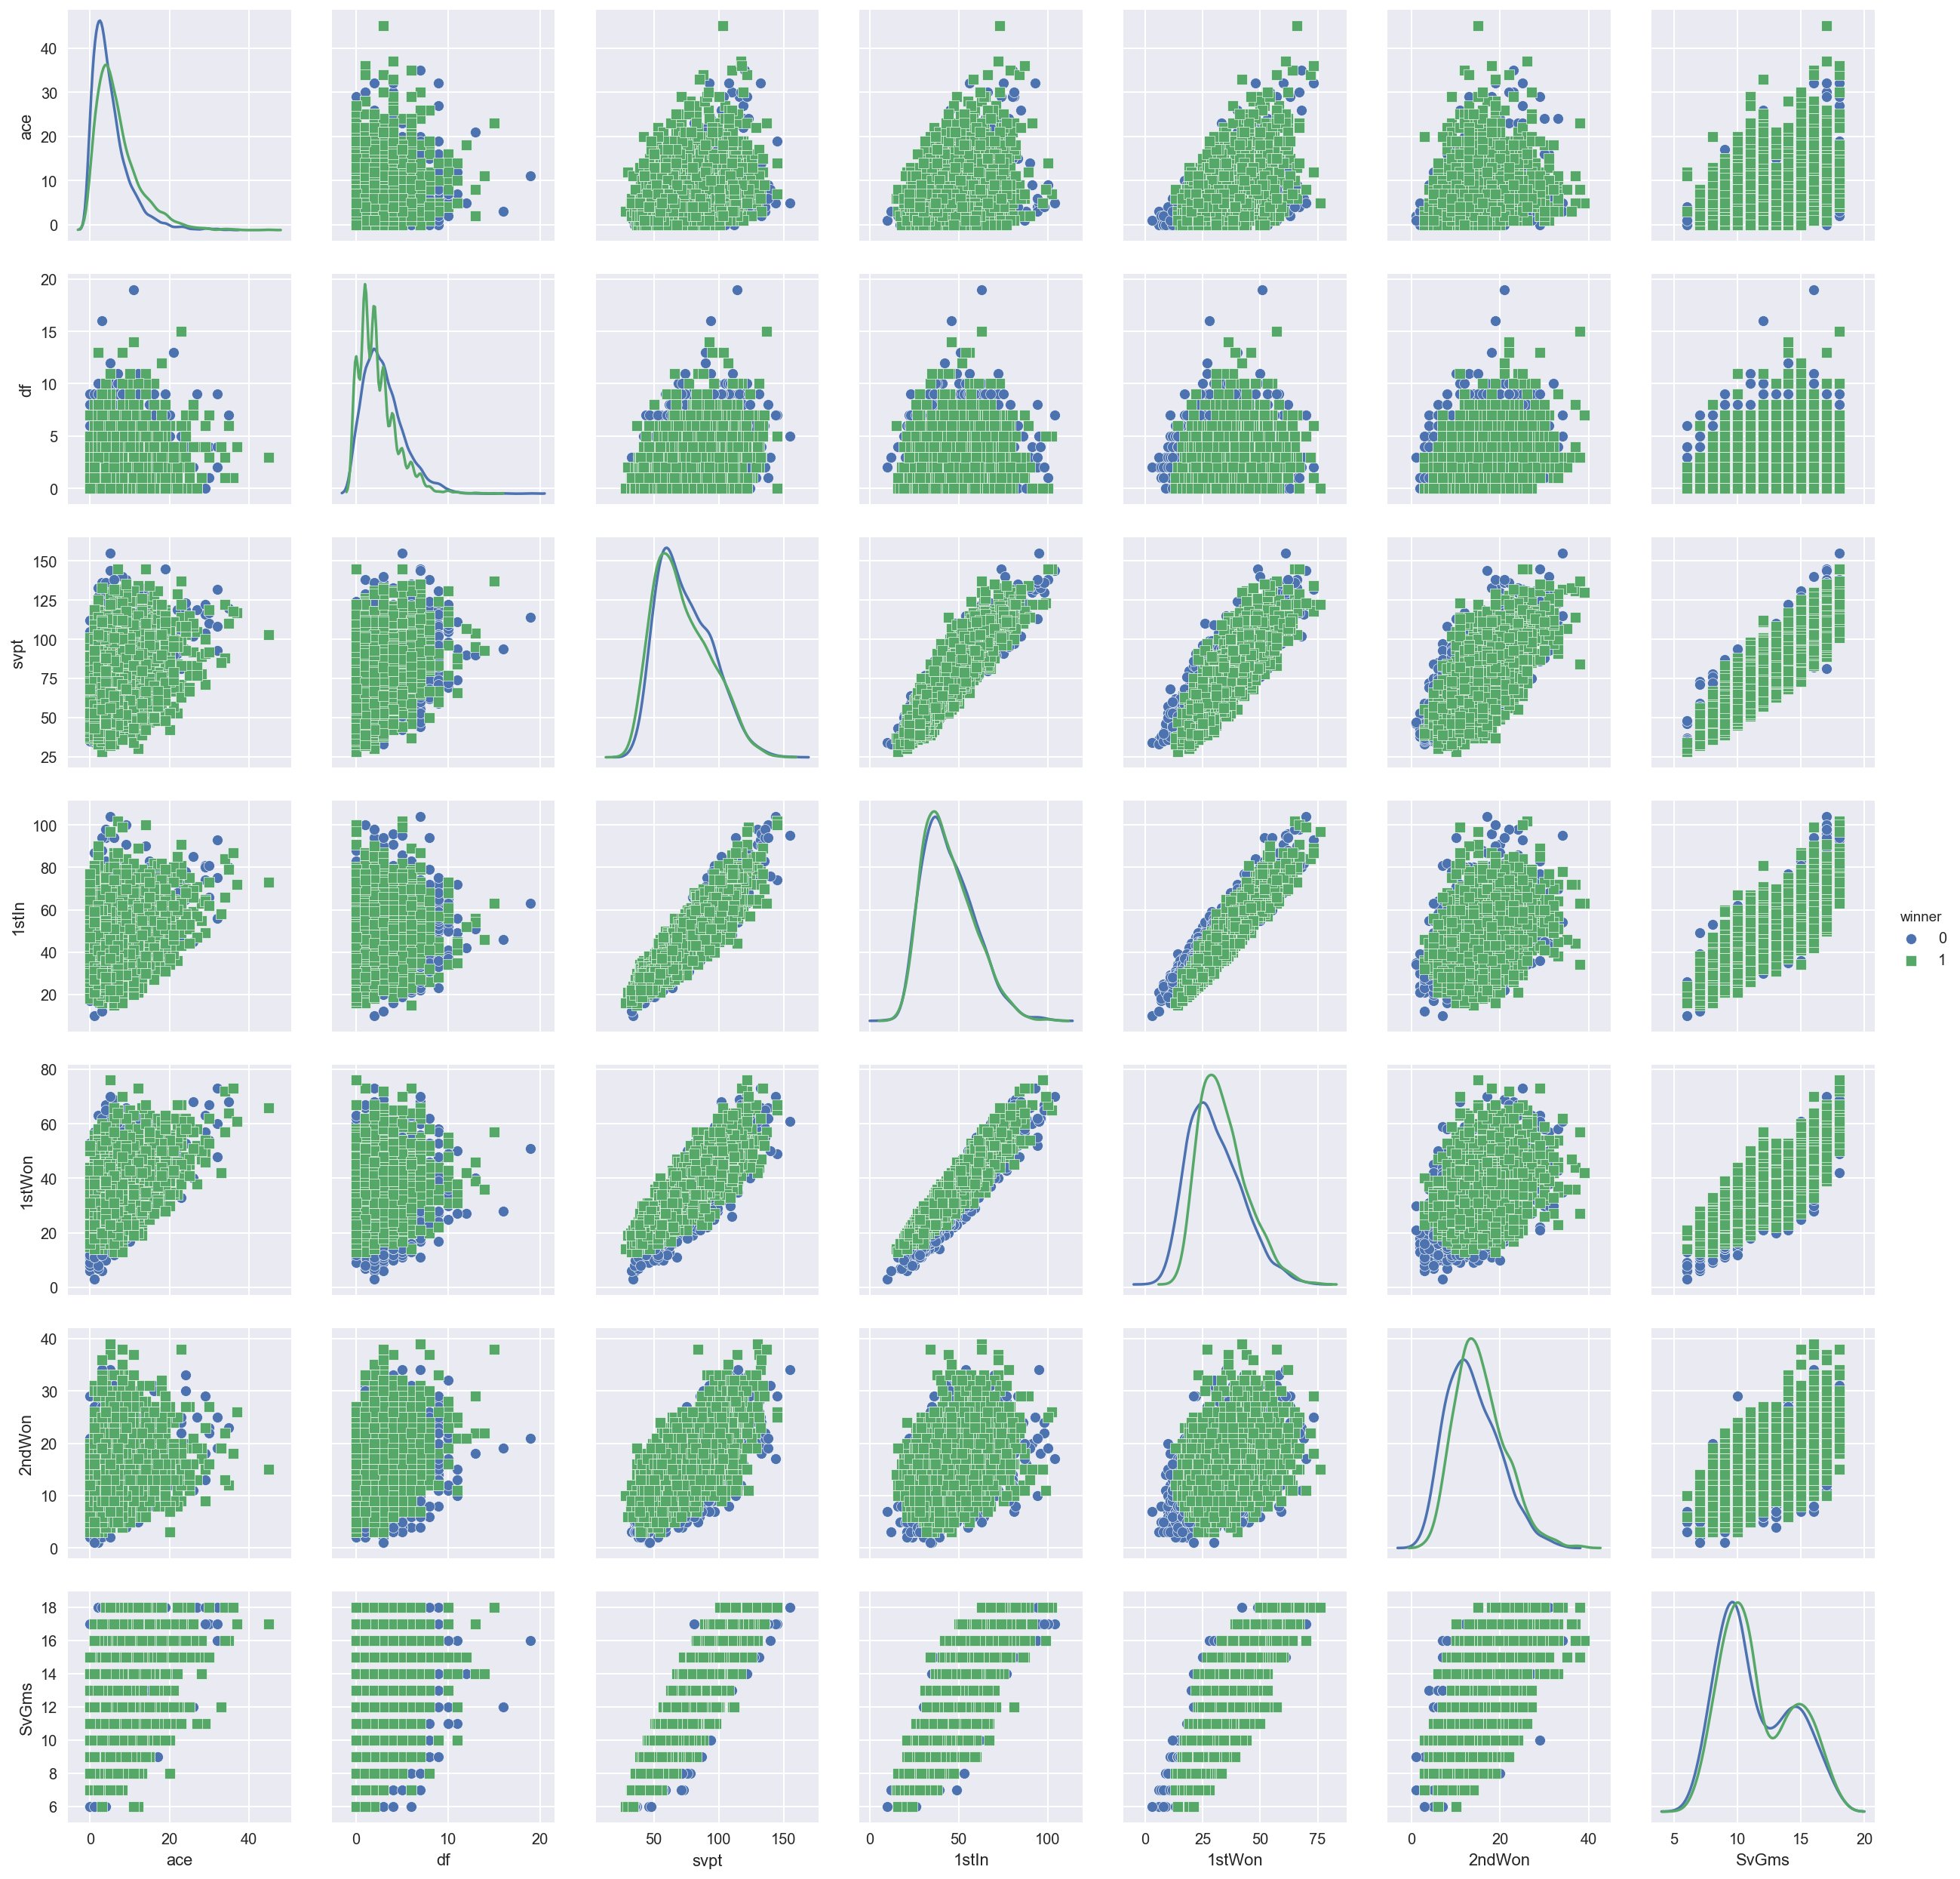

In [10]:
import seaborn as sns
from pandas.tools.plotting import scatter_matrix

sns.set()

g = sns.pairplot(df, hue="winner", diag_kind="kde",markers=["o", "s"], vars=['ace', 'df', 'svpt','1stIn','1stWon','2ndWon','SvGms']);



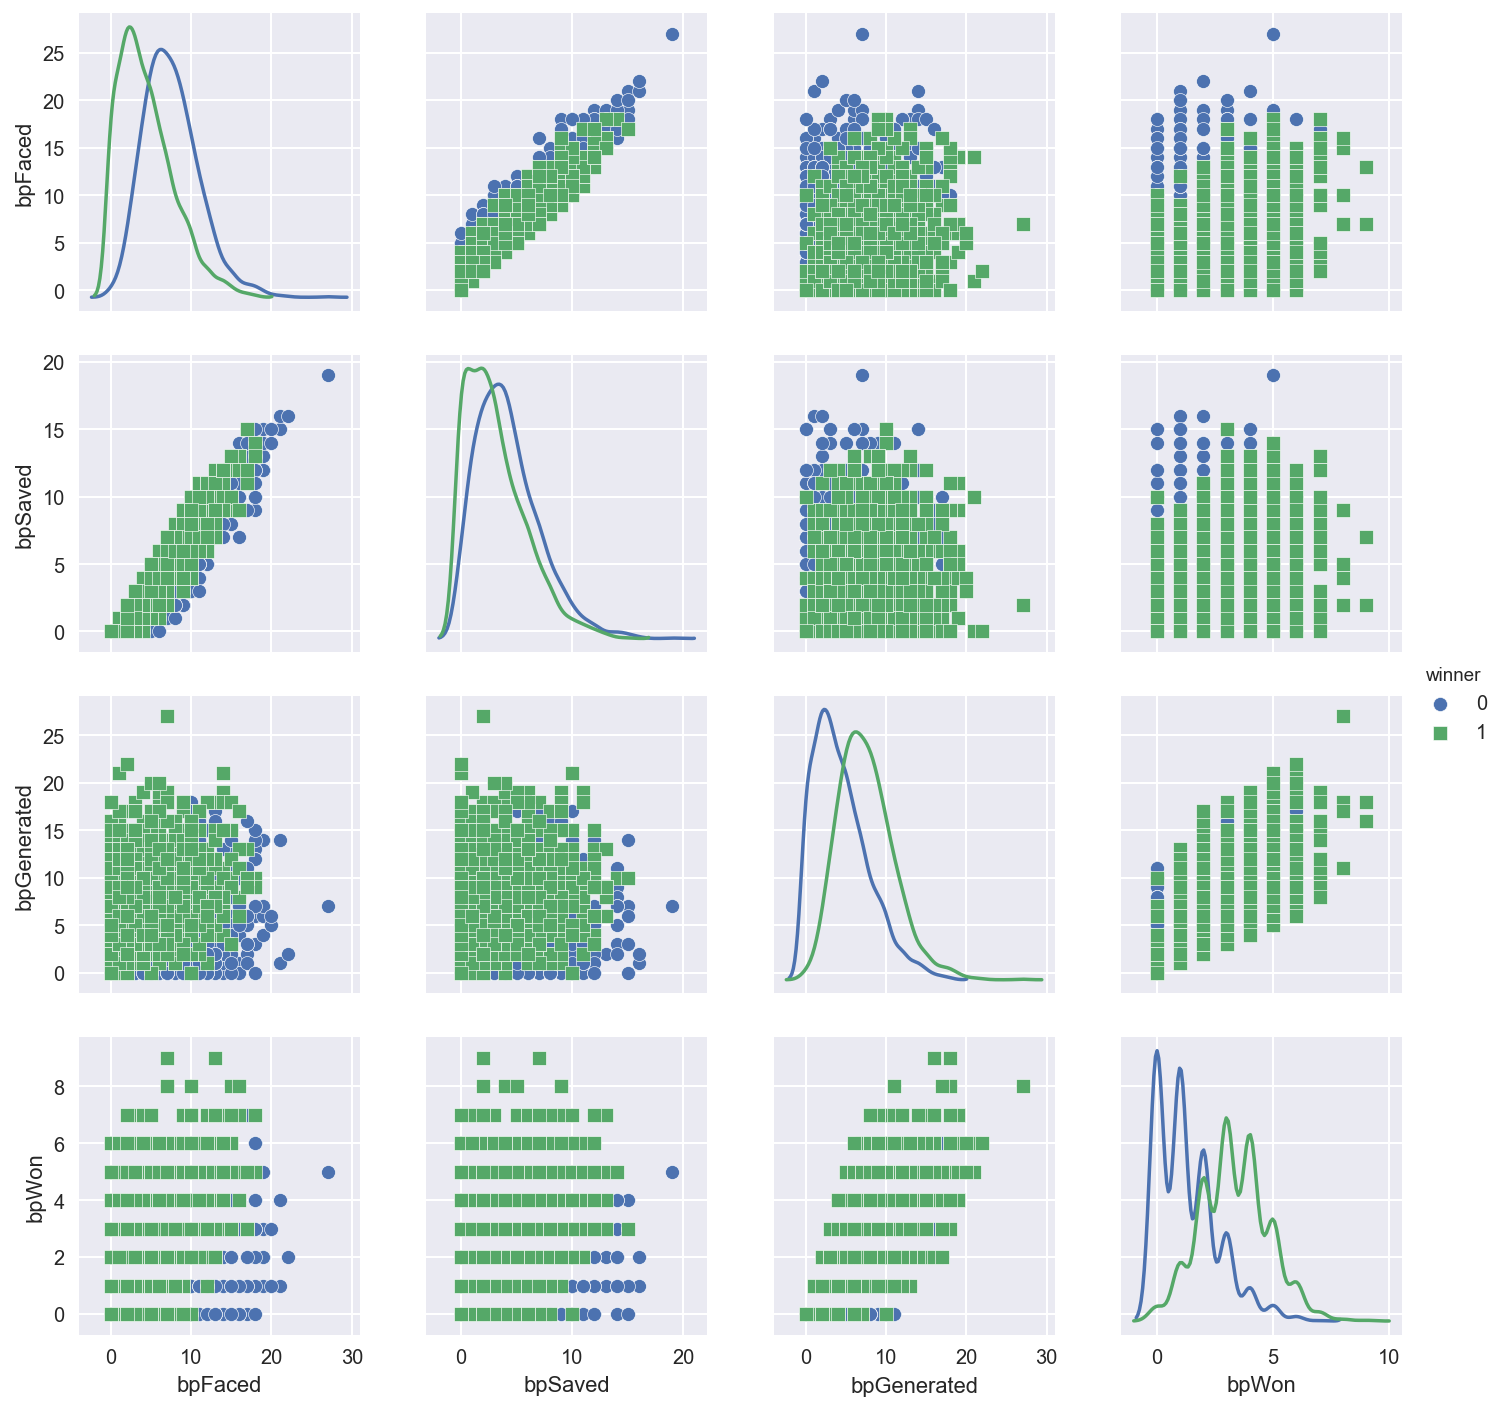

In [11]:
sns.pairplot(df, hue="winner", diag_kind="kde",markers=["o", "s"], vars=['bpFaced','bpSaved','bpGenerated','bpWon']);

plt.savefig('images/week5/pairplot.png')

## A simple decision tree

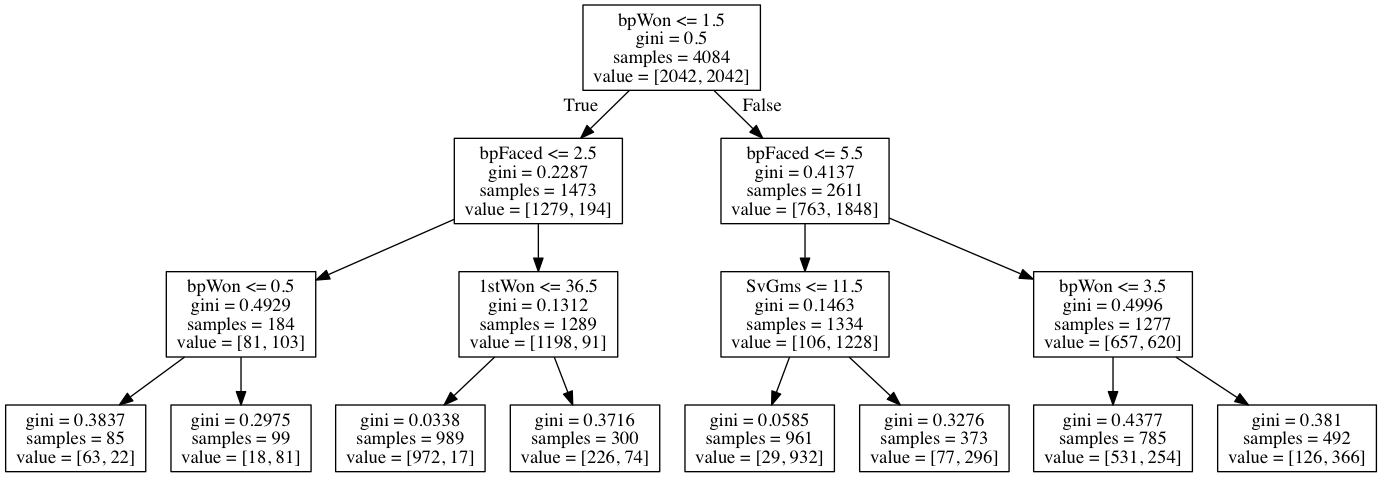

In [111]:
from IPython import display
from sklearn import datasets, tree, utils
from sklearn.externals.six import StringIO  
import pydotplus as pydot


Y_train = np.asarray(Y)

tree_clf = tree.DecisionTreeClassifier(max_depth=3).fit(X,list(Y.values))

# Generate a plot of the decision tree
dot_data = StringIO() 
tree.export_graphviz(tree_clf, out_file=dot_data, feature_names = X.columns); 
graph = pydot.graph_from_dot_data(dot_data.getvalue());
display.Image(graph.create_png())

#graph.write_png('images/week5/decisiontree.png')


As expected, the decision tree splits the data first on the bpWon feature. A small value obviously leads to a lose in most games. This simple tree achieves an accuracy of around 84%. Next, find the best parameters for more complex models like Random Forest, ExtraTrees and Gradient Boostin and compare them to the simple tree approach.

In [16]:
from sklearn.pipeline import make_pipeline
from sklearn import tree, ensemble
from sklearn.grid_search import GridSearchCV

model = make_pipeline(tree.DecisionTreeClassifier())
model.get_params()

parameters = {'decisiontreeclassifier__max_depth':[3,4]}

gs = GridSearchCV(model, parameters, cv=3, n_jobs=-1) 
gs.fit(X.values,list(Y.values))

print(gs.best_score_)
print(gs.best_params_)

0.841821743389
{'decisiontreeclassifier__max_depth': 3}


In [13]:
from sklearn.pipeline import make_pipeline
from sklearn import tree, ensemble
from sklearn.grid_search import GridSearchCV

model = make_pipeline(ensemble.RandomForestClassifier())
model.get_params()

parameters = {'randomforestclassifier__n_estimators': list(range(1,400,100)),
              'randomforestclassifier__min_samples_leaf': list(range(1,4,1))}

gs_forest = GridSearchCV(model, parameters, cv=3, n_jobs=-1) 
gs_forest.fit(X.values,list(Y.values))

print(gs.best_score_)
print(gs.best_params_)


0.897894221352
{'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__n_estimators': 301}


In [29]:
model = make_pipeline(ensemble.ExtraTreesClassifier())
model.get_params()


parameters = {'extratreesclassifier__n_estimators': list(range(1,400,100)),
              'extratreesclassifier__min_samples_leaf': list(range(1,4,1))}

gs_extraTree = GridSearchCV(model, parameters, cv=3, n_jobs=-1) 
gs_extraTree.fit(X.values,list(Y.values))

print(gs_extraTree.best_score_)
print(gs_extraTree.best_params_)

0.899118511263
{'extratreesclassifier__min_samples_leaf': 1, 'extratreesclassifier__n_estimators': 201}


In [33]:
model = make_pipeline(ensemble.GradientBoostingClassifier())
model.get_params()


parameters = {'gradientboostingclassifier__n_estimators': list(range(100,401,100)),
              'gradientboostingclassifier__min_samples_leaf': list(range(1,4,1))}

gs_gradientBoost = GridSearchCV(model, parameters, cv=3, n_jobs=-1) 
gs_gradientBoost.fit(X.values,list(Y.values))

print(gs_gradientBoost.best_score_)
print(gs_gradientBoost.best_params_)

0.913075416259
{'gradientboostingclassifier__n_estimators': 300, 'gradientboostingclassifier__min_samples_leaf': 1}


In [12]:
from sklearn import cross_validation
from sklearn import tree, ensemble
import pandas as pd

n_samples = X.shape[0]
cv = cross_validation.ShuffleSplit(n_samples, n_iter=20, test_size=0.2, random_state=42)
def compute_error(clf, X, y):
    return cross_validation.cross_val_score(clf, X, y, cv=cv).mean()

tree_reg = tree.DecisionTreeClassifier(max_depth=3)
forest_reg = ensemble.RandomForestClassifier(min_samples_leaf = 1, n_estimators=300)
extra_reg = ensemble.ExtraTreesClassifier(min_samples_leaf = 1, n_estimators=200)
gradient_reg = ensemble.GradientBoostingClassifier(min_samples_leaf = 1, n_estimators=300)

# color_list = ['b', 'g', 'r', 'c']
model_performance = pd.DataFrame([
   # ("Mean Model", Y.var()),
    ("Decision Tree", compute_error(tree_reg, X, list(Y.values))),
    ("Random Forest", compute_error(forest_reg, X, list(Y.values))),
    ("Extra Random Forest", compute_error(extra_reg, X, list(Y.values))),
    ("Gradient Boosted Classifier", compute_error(gradient_reg, X, list(Y.values)))
], columns=["Model", "Accuracy"])


## Performance of models

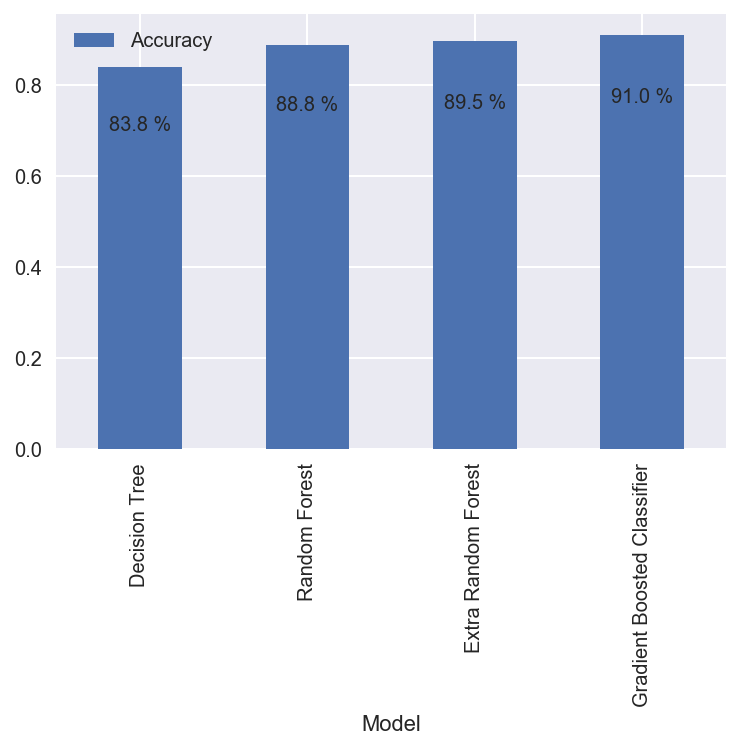

In [112]:

ax = model_performance.plot(x="Model", y="Accuracy", kind="Bar");

for p in ax.patches:
    val = "{} %".format(np.round(p.get_height(),decimals=3)*100)
    ax.annotate(val, (p.get_x()+p.get_width()/2., p.get_height()*0.85), ha='center', va='center')
    
plt.savefig('images/week5/accuracy.png', bbox_inches="tight")

As expected the more complex models allow for a more accurate classification. But this comes at the cost of higher training time and less interpretability. It is interesting to look at the importance of the different features over all trained models.

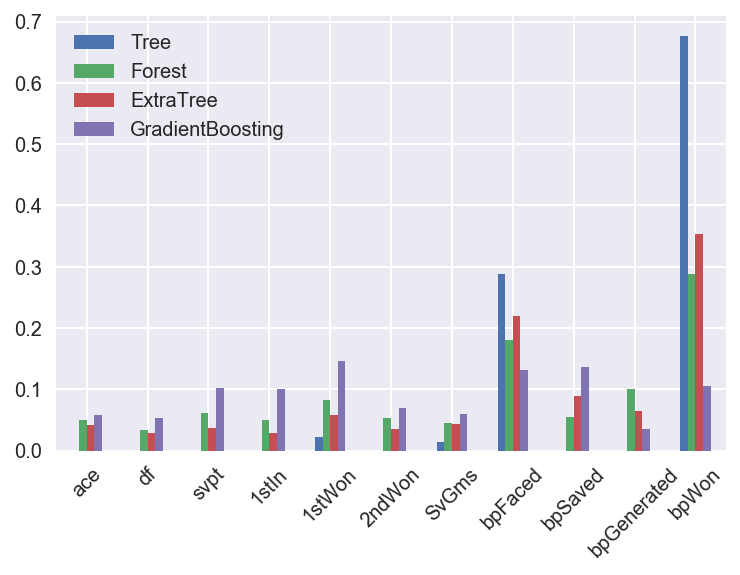

In [113]:
pd.DataFrame([
    tree_reg.fit(X, list(Y.values)).feature_importances_,
    ensemble.RandomForestClassifier(min_samples_leaf=1,n_estimators=300).fit(X, list(Y.values)).feature_importances_,
    ensemble.ExtraTreesRegressor(min_samples_leaf = 1, n_estimators=200).fit(X, list(Y.values)).feature_importances_,
    ensemble.GradientBoostingClassifier(min_samples_leaf = 1, n_estimators=300).fit(X, list(Y.values)).feature_importances_
], columns=X.columns, index=["Tree",'Forest','ExtraTree','GradientBoosting']).T.plot(kind="bar",rot=45).legend(loc="upper left");
plt.savefig('images/week5/features.png', bbox_inches="tight")

We see that the depth-three decision tree trusts bpWon and bpFaced for the classification. Also most other models identify both features as important. Only gradient boosting based more weight on the other features.

## Predict the winning probability for Wawrinka vs Stepanek

In [11]:
print(tree_clf.predict_proba([[11.0,  2.0,   57.0,   37.0,    30.0,    12.0,   11.0,      1.0,      0.0, 5.0, 3.0]])
)



[[ 0.0301769  0.9698231]]


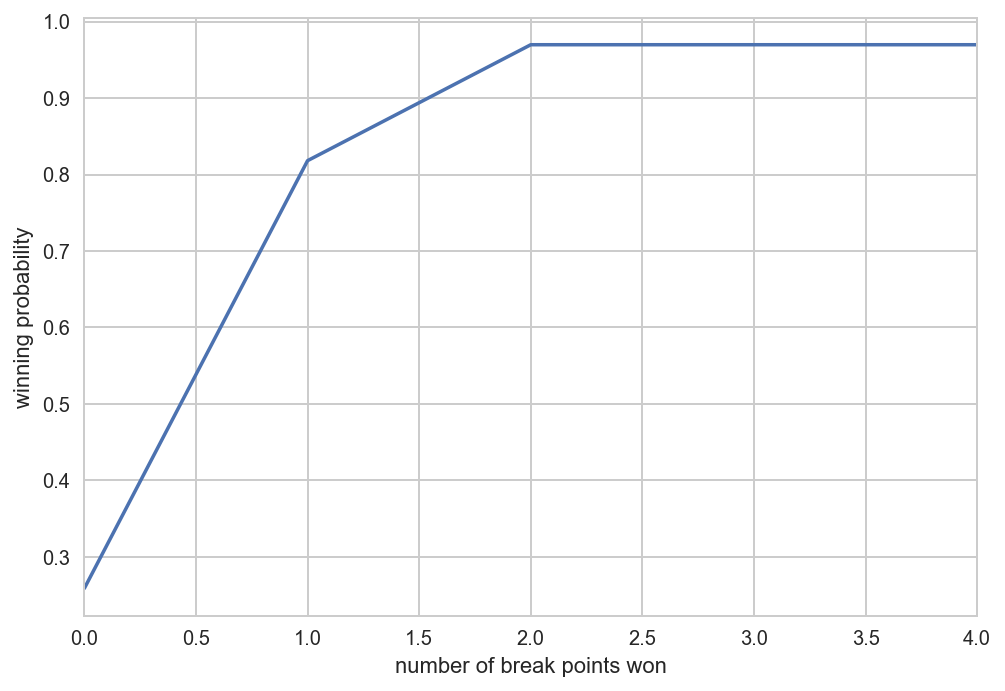

In [13]:
df_study = []
for bpWon in range(0,5):
    lose, win = tree_clf.predict_proba([[11.0,  2,   57.0,   37.0,    30.0,    12.0,   11.0,      1.0,      0.0,5.0,bpWon]])[0]
    df_study.append(win)
#print(df_study)

ax = pd.Series(df_study).plot()
ax.set_xlabel("number of break points won");
ax.set_ylabel("winning probability");



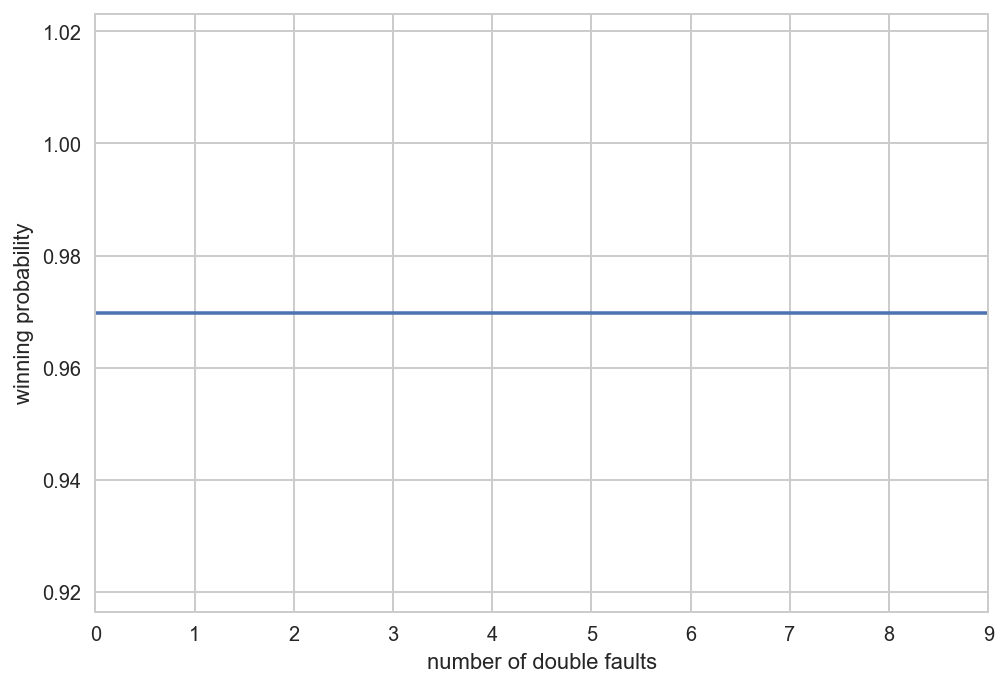

In [14]:
df_study = []
for dfaults in range(0,10):
    lose, win = tree_clf.predict_proba(np.array([[11.0,  dfaults,   57.0,   37.0,    30.0,    12.0,   11.0,      1.0,      0.0,5.0,3.0]]))[0]
    df_study.append(win)
#print(df_study)

ax = pd.Series(df_study).plot()
ax.set_xlabel("number of double faults");
ax.set_ylabel("winning probability");



The simple tree model prediction is independent of the number of double faults as no splitting occurs on this feature. 

## Lasso
We can also use L1 regularization to find a sparse representation of the features. Lasso does not lead to a very accurate model but it also identifies the features bpWon and bpFaced as very important for a prediction.

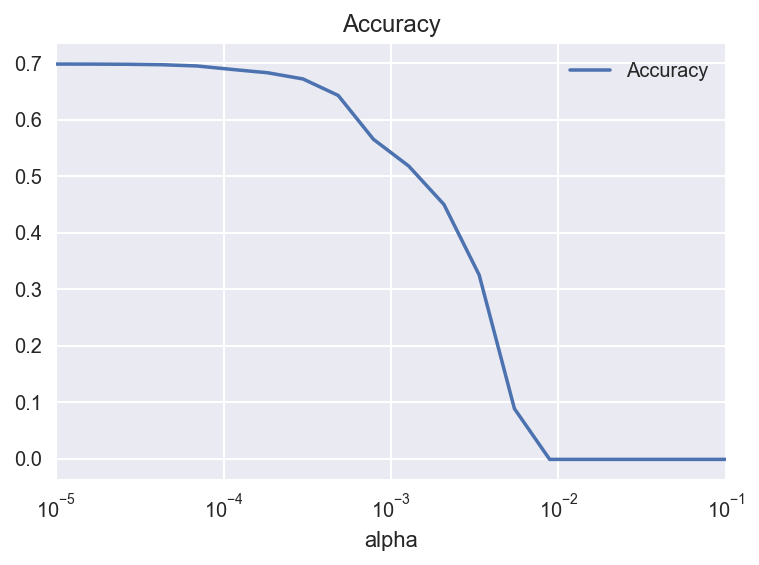

In [109]:
from sklearn import linear_model
# Lasso Regression with cross validation
np.random.seed(42)
alphas = np.logspace(-5., -1., 20)

lasso_models = pd.DataFrame(
    [(alpha,
      "Lasso with alpha = %f" % alpha,
      compute_error(linear_model.LassoLars(alpha=alpha), XL, YL)) for alpha in alphas],
    columns=['alpha', 'Model', 'Accuracy'])
lasso_models.plot(x='alpha', y='Accuracy', logx=True, title='Accuracy');

plt.savefig('images/week5/lassoLogisticRegressionAccuracy.png')

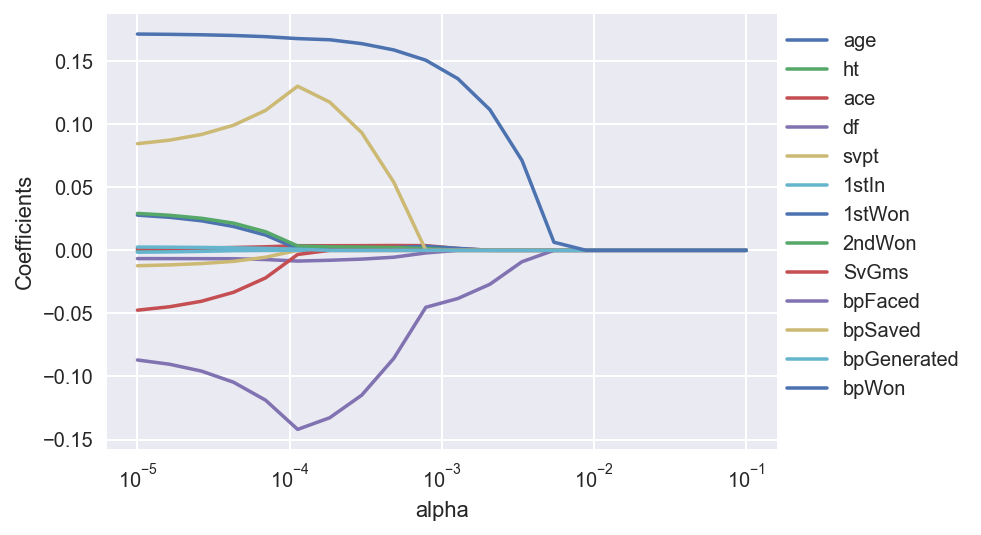

In [114]:
coefs = np.array([linear_model.LassoLars(alpha=alpha).fit(XL, YL).coef_
                  for alpha in alphas])

ax = plt.semilogx(alphas, coefs)
plt.xlabel('alpha')
plt.ylabel('Coefficients')
plt.legend(labels = XL.columns,bbox_to_anchor=(1.3, 1), loc='upper right', ncol=1);
plt.savefig('images/week5/LassoLogisticRegessionCoefficients.png',bbox_inches="tight")

# Next week
## Supervised learning
- Age - Performance curve for ATP Tour players
- Inspect variation of player statistics for player (e.g. Stan Wawrinka)

## Unsupervised learning
- Group players by their average statistics (k-means)
- Visualize clusters using PCA

In [ ]:
# compute avg. statistics of each player of Top 20 and run k-means on it (only include players with enough matches)
# split on surfaces, train four different k-means and one with all four statistics
#  Use cluster centroids as avg. statistics you have to beat with your statistics to win using model from above
# use pca or whatever to plot the clusters